In [1]:
import torch
from torch import nn, optim  
import pandas as pd
from data_processing import preprocessing_german, preprocessing_adult 
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score 
from utils import Logger, DatasetLoader
from torch.autograd import Variable

import matplotlib.pyplot as plt
from model import MLP
import warnings
warnings.simplefilter("ignore")

In [2]:
def train_test_split2(X, y, S, test_size=0.3):
    split_size = int(X.shape[0] * test_size)
    X_test, y_test, s_test = X[0:split_size, :], y[0:split_size], S[0:split_size]
    X_train, y_train, s_train  = X[split_size+1:, :], y[split_size+1:], S[split_size+1:]
    print(split_size)
    print(X_train.shape, y_train.shape)
    return torch.from_numpy(X_train), torch.from_numpy(X_test), torch.from_numpy(y_train), torch.from_numpy(y_test), torch.from_numpy(s_train), torch.from_numpy(s_test)

### Load the German dataset and preprocess it

In [3]:
train_data = pd.read_csv("./dataset/german.data.csv")
#test_data = pd.read_csv("./dataset/german.test.csv")
n_data = 32561 
X, y, S, data = preprocessing_german(train_data) 

X_train, X_test, y_train, y_test, S_train, S_test =  train_test_split2(X, y, S, test_size=0.3)
X = torch.from_numpy(X)
y = torch.from_numpy(y)
S = torch.from_numpy(S)  
DATA_SET_NAME = "German"


300
(699, 31) (699,)


Load Adult Income dataset

In [4]:
'''train_data = pd.read_csv("./dataset/adult.data.csv")
#test_data = pd.read_csv("./dataset/german.test.csv")
n_data = 32561 
X, y, S, data = preprocessing_adult(train_data, n_data) 

X_train, X_test, y_train, y_test, S_train, S_test =  train_test_split2(X, y, S, test_size=0.3)
X = torch.from_numpy(X)
y = torch.from_numpy(y)
S = torch.from_numpy(S)  
DATA_SET_NAME = "Adult"'''

'train_data = pd.read_csv("./dataset/adult.data.csv")\n#test_data = pd.read_csv("./dataset/german.test.csv")\nn_data = 32561 \nX, y, S, data = preprocessing_adult(train_data, n_data) \n\nX_train, X_test, y_train, y_test, S_train, S_test =  train_test_split2(X, y, S, test_size=0.3)\nX = torch.from_numpy(X)\ny = torch.from_numpy(y)\nS = torch.from_numpy(S)  \nDATA_SET_NAME = "Adult"'

In [5]:
n_feature = X.shape[1]
latent_dim = 8 # latent dim space as in LAFTR
logger = Logger('AutoEncoder', DATA_SET_NAME)
print(X.shape)

torch.Size([1000, 31])


In [6]:
# prepare training and testing data
training_data = DatasetLoader(X, y, S)
test_data = DatasetLoader(X_test, y_test, S_test)

In [7]:
has_gpu = torch.cuda.is_available() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# batch size
batch_size = 64*2

### Methods to train a neural network based classifier to assess the fairness performances of a representation

In [8]:
results = {}
confusion_metric_results = {}

### Train the auto encoder, classifier, adversary and compare the fairness performances of learned representation on some classsical ML algorithms

We are using our [own](./fairness_metrics.py) implementation of fairness metrics [fairlearn](https://fairlearn.org/v0.7.0/api_reference/fairlearn.metrics.html) package can be used as well.

In [9]:
from fairlearn.metrics import equalized_odds_difference, demographic_parity_difference, false_negative_rate_difference
from sklearn.metrics import accuracy_score 
from fairness_metrics import cross_val_fair_scores, statistical_parity_score, confusion_matrix_score


from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_val_score, KFold

In [10]:
from model import DemParModel, EqualOddModel, EqualOppModel
from trainer import Trainer, train_classifier

In [11]:
data_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True) 
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True) 

### train a model on the original dataset

In [12]:
results = {}

kfold = KFold(n_splits=5)
clr = LogisticRegression(max_iter=1000) 

acc_, dp_, eqodd_, eopp_ = cross_val_fair_scores(clr, X_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(), kfold, S_train.cpu().detach().numpy())  
results["Unfair"] = ([np.mean(acc_), np.mean(dp_), np.mean(eqodd_), np.mean(eopp_)], [np.std(acc_), np.std(dp_), np.std(eqodd_), np.std(eopp_)]) 
 
print("Accuracy:{:.3f} (+/-) {:.3f} ".format(np.mean(acc_), np.std(acc_))) 
print("demographic parity:{:.3f} (+/-) {:.3f} ".format(np.mean(dp_), np.std(dp_)))  
print("equlized odd score:{:.3f} (+/-){:.3f} ".format(np.mean(eqodd_), np.std(eqodd_)))
print("equal opportunity score:{:.3f} (+/-){:.3f} ".format(np.mean(eopp_), np.std(eopp_)))

Accuracy:0.745 (+/-) 0.037 
demographic parity:0.115 (+/-) 0.047 
equlized odd score:0.239 (+/-)0.124 
equal opportunity score:0.053 (+/-)0.040 


### learn fair representation

0it [00:00, ?it/s]

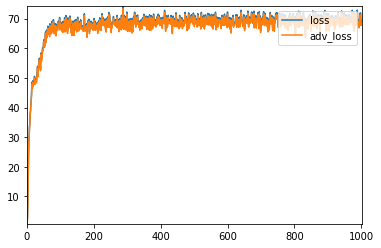

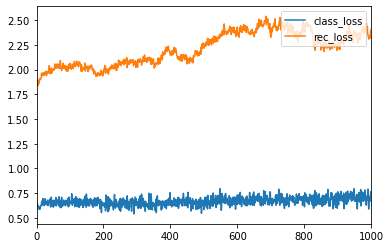

1000it [07:58,  2.09it/s]


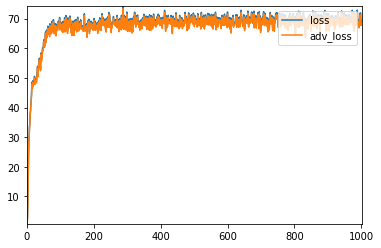

In [13]:
model = DemParModel(n_feature=n_feature, latent_dim=15, class_weight=1, recon_weight=0, adv_weight=1, hidden_layers={'class': 20, 'ae': 20, 'avd': 20}) 
trainer = Trainer(model, data_loader, DATA_SET_NAME, "LFR")
parts = ["autoencoder", "classifier"]
trainer.train_privacy(parts, 1000)

We test the learned mapping function on test data and measure the accuracy and fairness

In [14]:
kfold = KFold(n_splits=5)
X_transformed = model.transform(X_test.to(device))  
clr = LogisticRegression(max_iter=1000)  
acc_, dp_, eqodd_, eopp_ = cross_val_fair_scores(clr, X_transformed.cpu().detach().numpy(), y_test.cpu().detach().numpy(), kfold, S_test.cpu().detach().numpy())
scores_ = [np.mean(acc_), np.mean(dp_), np.mean(eqodd_), np.mean(eopp_)]  
std_ = [np.std(acc_), np.std(dp_), np.std(eqodd_), np.std(eopp_)]  
results[model.name] = (scores_, std_)

Plot the results to compare fairness and accuracy on the original dataset and the learned fair representation

[]

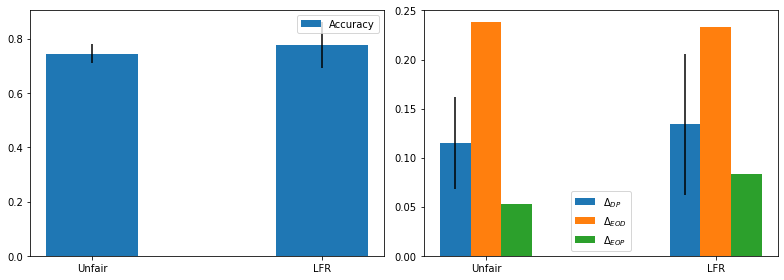

In [15]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(11,4))
x = np.arange(len(results))
width = .4
plot_names, plot_values, sdt_values = [], [], []
for name in results:
    plot_names.append(name)
    metrics, stds = results[name]
    plot_values.append(metrics)
    sdt_values.append(stds)


plot_values = np.array(plot_values)
sdt_values = np.array(sdt_values)
#print(plot_values)
ax[0].bar(x, plot_values[:, 0], width, yerr=sdt_values[:, 0], label='Accuracy')
ax[1].bar(x-width/3, plot_values[:, 1], width/3,  yerr=sdt_values[:, 1], label='$\Delta_{DP}$')
ax[1].bar(x, plot_values[:, 2], width/3, label='$\Delta_{EOD}$')
ax[1].bar(x+width/3, plot_values[:, 3], width/3, label='$\Delta_{EOP}$')

for i in [0,1]:
    ax[i].set_xticks(x)  
    ax[i].set_xticklabels(plot_names) 
    ax[i].legend()
fig.tight_layout()
plt.plot()